In [1]:
import numpy as np
import pandas as pd 
import os

import shutil 
from tqdm import tqdm

import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

from collections import OrderedDict
import torch.nn as nn

from torchvision import transforms, models

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
def foldering_data(data_root, class_names):
    
    train_dir = 'train'
    test_dir = 'test'
    val_dir = 'val'

    

    for dir_name in [train_dir, test_dir, val_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        source_dir_train = os.path.join(data_root, 'train', class_name)
        for i, file_name in enumerate(tqdm(os.listdir(source_dir_train))):
            if i % 10 != 0:
                dest_dir = os.path.join(train_dir, class_name) 
            else:
                dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir_train, file_name), os.path.join(dest_dir, file_name))
            
    for class_name in class_names:
        source_dir_test = os.path.join(data_root, 'test', class_name)
        for i, file_name in enumerate(tqdm(os.listdir(source_dir_test))):
            dest_dir = os.path.join(test_dir, class_name) 
            shutil.copy(os.path.join(source_dir_test, file_name), os.path.join(dest_dir, file_name))

In [4]:
class_names = ['altar', 'apse', 'bell_tower', 'column','dome(inner)','dome(outer)',\
                   'flying_buttress','gargoyle','stained_glass','vault']
data_root = '../input/architectural-heritage-elements-image64-dataset'
foldering_data(data_root, class_names)

100%|██████████| 163/163 [00:00<00:00, 183.23it/s]


In [9]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(MLPWithDropout, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_prob = dropout_prob

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(1, len(hidden_sizes)):
            self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        
        self.dropout_layers = nn.ModuleList()
        for _ in range(len(hidden_sizes)):
            self.dropout_layers.append(nn.Dropout(dropout_prob))
        
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        
        for fc_layer, dropout_layer in zip(self.fc_layers, self.dropout_layers):
            x = torch.relu(fc_layer(x))
            x = dropout_layer(x)
    
        x = self.output_layer(x)
        return x

In [242]:
class CNN01(nn.Module):
    
    def __init__(self, shape = None, hidden_size = None):
        super(CNN01, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 8, kernel_size = 3, padding = 1, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 8, out_channels = 3, kernel_size = 3, padding = 1, stride = 2)
        self.relu = nn.ReLU()
        
        input_size = 2352
        hidden_sizes = [256, 128, 64]
        output_size = 10 
        dropout_prob = 0.2 # dropout probability
        self.fc = MLPWithDropout(input_size, hidden_sizes, output_size, dropout_prob)
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
#         return x.view(x.size(0), -1)
        return self.fc((x.view(x.size(0), -1)))
    
    def get_conv_layers(self, x):
        output = {}
        output['conv1'] = self.conv1
        output['conv2'] = self.conv2
        output['conv3'] = self.conv3
        
        return output
        

In [245]:
model = CNN01()

In [246]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [321]:
def train_model(model, loss, optimizer, num_epochs):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  
            else:
                dataloader = val_dataloader
                model.eval()   

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model, train_loss, train_acc, val_loss, val_acc

In [248]:
def data_preprocessing(train_dir, val_dir, test_folder):
    
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_dataset = torchvision.datasets.ImageFolder(test_folder, val_transforms)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader, test_dataloader

In [304]:
train_dataloader, val_dataloader, test_dataloader = data_preprocessing('train', 'val', 'test')

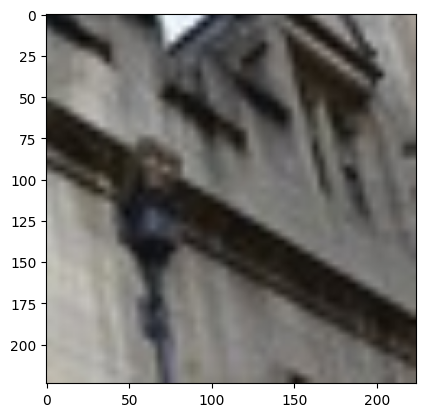

In [250]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [322]:
_, train_loss, train_acc, val_loss, val_acc = train_model(model, loss, optimizer, num_epochs=10)

Epoch 0/9:


100%|██████████| 142/142 [00:12<00:00, 11.25it/s]


train Loss: 1.1642 Acc: 0.6009


100%|██████████| 16/16 [00:01<00:00,  9.54it/s]

val Loss: 0.9785 Acc: 0.6619
Epoch 1/9:



100%|██████████| 142/142 [00:12<00:00, 11.09it/s]


train Loss: 1.1566 Acc: 0.6034


100%|██████████| 16/16 [00:01<00:00, 10.70it/s]

val Loss: 0.9302 Acc: 0.6678
Epoch 2/9:



100%|██████████| 142/142 [00:12<00:00, 11.51it/s]


train Loss: 1.1760 Acc: 0.5936


100%|██████████| 16/16 [00:01<00:00, 10.77it/s]

val Loss: 0.9464 Acc: 0.6691
Epoch 3/9:



100%|██████████| 142/142 [00:12<00:00, 11.36it/s]


train Loss: 1.1741 Acc: 0.5928


100%|██████████| 16/16 [00:01<00:00, 10.98it/s]

val Loss: 0.9227 Acc: 0.6740
Epoch 4/9:



100%|██████████| 142/142 [00:12<00:00, 11.41it/s]


train Loss: 1.1540 Acc: 0.6087


100%|██████████| 16/16 [00:01<00:00, 10.94it/s]

val Loss: 0.9454 Acc: 0.6707
Epoch 5/9:



100%|██████████| 142/142 [00:12<00:00, 11.27it/s]


train Loss: 1.1677 Acc: 0.5971


100%|██████████| 16/16 [00:01<00:00, 10.85it/s]

val Loss: 0.9564 Acc: 0.6622
Epoch 6/9:



100%|██████████| 142/142 [00:12<00:00, 11.57it/s]


train Loss: 1.1578 Acc: 0.5945


100%|██████████| 16/16 [00:01<00:00, 10.57it/s]

val Loss: 0.9710 Acc: 0.6708
Epoch 7/9:



100%|██████████| 142/142 [00:12<00:00, 11.33it/s]


train Loss: 1.1737 Acc: 0.5964


100%|██████████| 16/16 [00:01<00:00, 10.65it/s]

val Loss: 0.9623 Acc: 0.6620
Epoch 8/9:



100%|██████████| 142/142 [00:12<00:00, 11.17it/s]


train Loss: 1.1617 Acc: 0.5980


100%|██████████| 16/16 [00:01<00:00, 10.83it/s]

val Loss: 0.9341 Acc: 0.6885
Epoch 9/9:



100%|██████████| 142/142 [00:12<00:00, 11.30it/s]


train Loss: 1.1631 Acc: 0.6027


100%|██████████| 16/16 [00:01<00:00,  9.77it/s]

val Loss: 0.9045 Acc: 0.6939


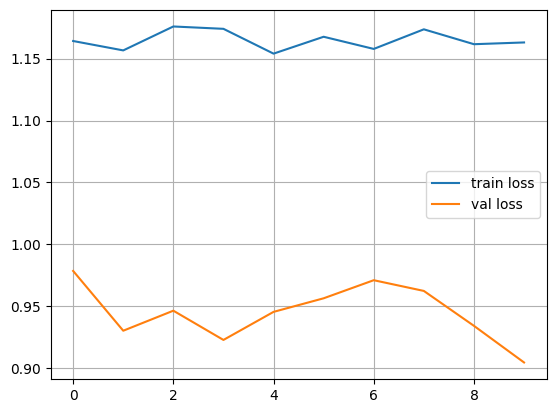

In [325]:
plt.plot(train_loss, label = 'train loss'), plt.plot(val_loss, label = 'val loss')
plt.grid()
plt.legend()

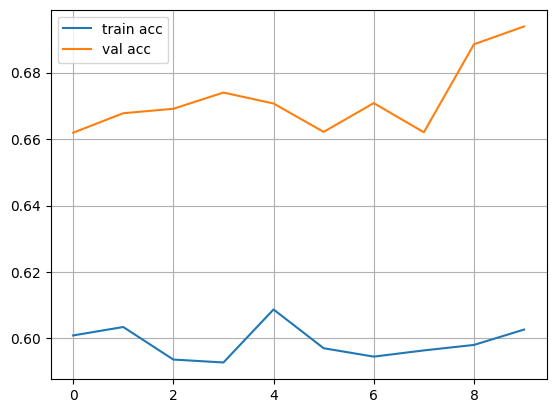

In [328]:
plt.plot([x.to('cpu') for x in train_acc], label = 'train acc'), plt.plot([x.to('cpu') for x in val_acc], label = 'val acc')
plt.grid()
plt.legend()

In [329]:
model.eval()

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
    test_class_predictions = test_predictions.argmax(axis=1)
    test_labels = labels.numpy()

In [330]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(test_labels, test_class_predictions)
print('Test Accuracy: {:.4f}'.format(test_accuracy), flush=True)

Test Accuracy: 0.6617


In [301]:
X_batch, y_batch = next(iter(test_dataloader_temp))

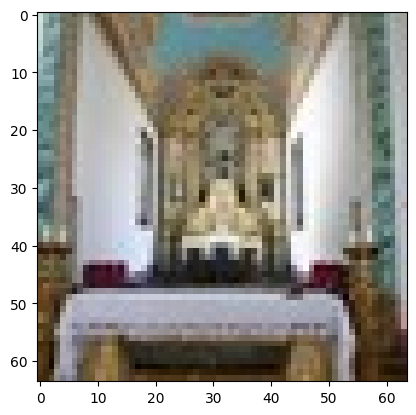

In [302]:
plt.imshow(X_batch[3].permute(1, 2, 0).numpy())

In [256]:
model.eval()
out = model.get_conv_layers(X_batch[3])

### visualizing the first kernel feature maps.

In [257]:
conv1 = out.get('conv1')

In [258]:
import seaborn as sns

In [259]:
feature_maps = conv1(X_batch[3].to(device))

In [260]:
def visualise_kernels(height, width, feature_maps):
    h = height
    w = width
    ix = 1
    for _ in range(h):
        for _ in range(w):
            # specify subplot and turn of axis
            ax = plt.subplot(h, w, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[ix-1, :, :].cpu().detach().numpy())
            ix += 1
    # show the figure
    plt.show()

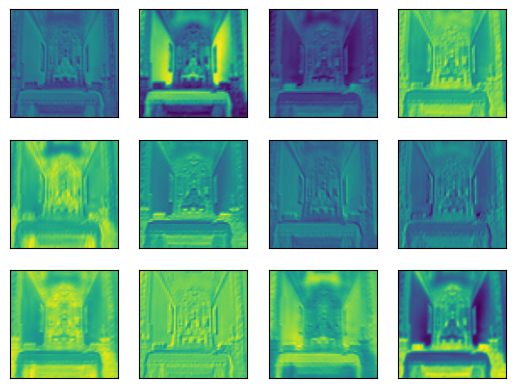

In [261]:
visualise_kernels(3, 4, feature_maps)

### visualizing the second kernel feature maps.

In [262]:
conv2 = out.get('conv2')

In [263]:
feature_maps2 = conv2(nn.functional.relu(feature_maps))

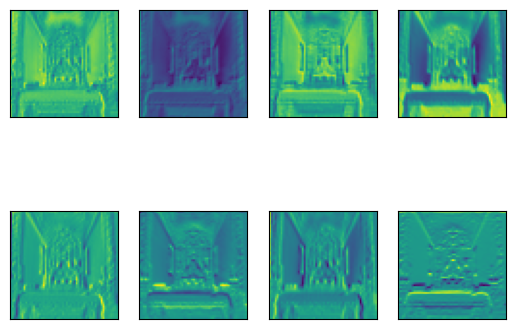

In [266]:
visualise_kernels(2, 4, feature_maps2)

### visualizing the third kernel feature maps.

In [267]:
conv3 = out.get('conv3')

In [268]:
feature_maps3 = conv3(nn.functional.relu(feature_maps2))

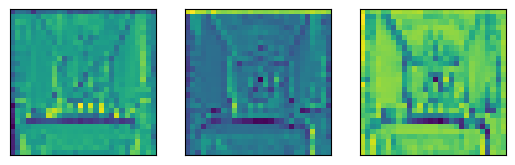

In [271]:
visualise_kernels(1, 3, feature_maps3)

# Deconv

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, padding = 1, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size = 3, padding = 1, stride = 2)

In [273]:
from math import floor, ceil
def Conv2DTranspose(X, W, padding="valid", strides=(1, 1)):
    # Define output shape before padding
    row_num = (X.shape[0] - 1) * strides[0] + W.shape[0]
    col_num = (X.shape[1] - 1) * strides[1] + W.shape[1]
    output = np.zeros([row_num, col_num])
    # Calculate the output
    for i in range(0, X.shape[0]):
        i_prime = i * strides[0] # Index in output
        for j in range(0, X.shape[1]):
            j_prime = j * strides[1]
            # Insert values
            for k_row in range(W.shape[0]):
                for k_col in range(W.shape[1]):
                    output[i_prime+k_row, j_prime+k_col] += W[k_row, k_col] * X[i, j]
    # Define length of padding
    if padding == "same":
        # returns the output with the shape of (input shape)*(stride)
        p_left = floor((W.shape[0] - strides[0])/2)
        p_right = W.shape[0] - strides[0] - p_left
        p_top = floor((W.shape[1] - strides[1])/2)
        p_bottom = W.shape[1] - strides[1] - p_left
    elif padding == "valid":
        # returns the output without any padding
        p_left = 0
        p_right = 0
        p_top = 0
        p_bottom = 0
    # Add padding
    output_padded = output[p_left:output.shape[0]-p_right, p_top:output.shape[0]-p_bottom]
    return(np.array(output_padded))

In [298]:
x = feature_maps3[0]
w = conv3.weight[0][0].T
out3 = Conv2DTranspose(x, w,padding = 'same', strides = (2, 2))

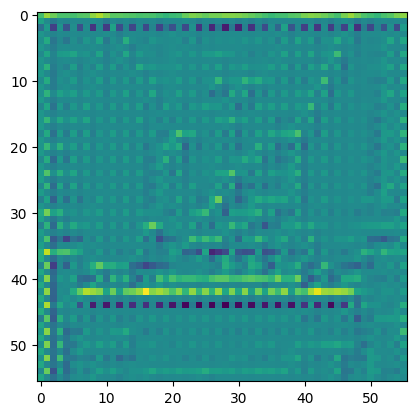

In [299]:
plt.imshow(out3)

In [296]:
x = feature_maps2[0]
w = conv2.weight[0][0].T
out2 = Conv2DTranspose(x, w,padding = 'same', strides = (2, 2))

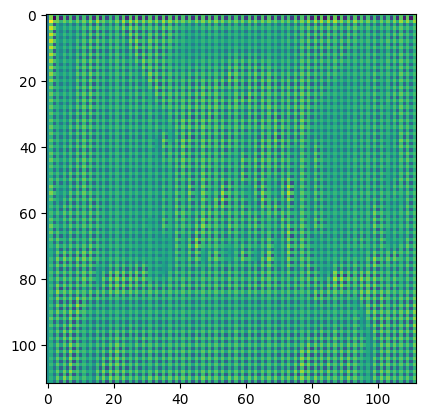

In [297]:
plt.imshow(out2)

In [294]:
x = feature_maps[0]
w = conv1.weight[0][0].T
out1 = Conv2DTranspose(x, w,padding = 'same', strides = (2, 2))

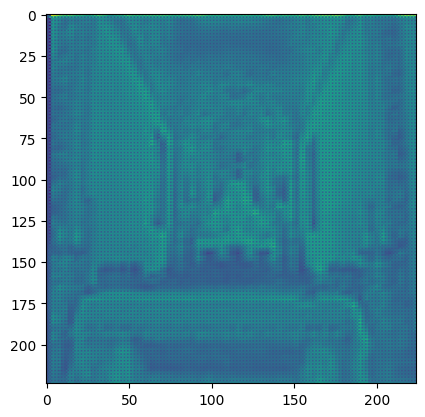

In [295]:
plt.imshow(out1)